# Housing Price Notebook

## Introduction 

The dataset of choice for my project is Kaggle's house price dataset (source: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

When starting any kind of data analysis project, it is important to have an endgoal in mind at the start. From this, we usually go about collecting the features afterwards that might allow us to work towards that goal (oftentimes the process is also the other way around, but that discussion is outside the scope of this project).

Let's say we're interested in the real estate market, for whatever reasons that may be, such as for scoping out investment opportunities, and that we are able to collect not only the house prices itself, but also some other miscellaneous information corresponding to said properties. 

The goal of this project is to find a relationship between the additional information, the physical or locational aspects, and the house prices themselves. To start with, let's see what information is included in this dataset.

In [1]:
# import libraries that will be used
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# read the data description, print the first 3 lines
with open("data_description.txt") as file:
    idx = 0
    for line in file:
        print(line)
        idx += 1
        if idx > 3: break

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER



Let's set out what we might want to know, and see if the data has the breadth necessary to answer them. 
1. How is house price related to geographical information? This includes more ephemeral features such as neighborhood (which is not entirely a physical thing) or proximity to certain locations.

2. How is house price related to the physical aspects of the property itself? Do bigger houses automatically lead to higher prices? What about the materials and the furnishing of the house?

3. How does the sale condition affect the house price? As in do the house prices get affected by time and other sale conditions?

In [3]:
# read and output the training set
train_df = pd.read_csv("train.csv").drop("Id", axis=1, inplace=False)
test_df = pd.read_csv("test.csv").drop("Id", axis=1, inplace=False)

# set global random seed
global_seed = 42

train_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We can see the 81 columns is enough to answer our 3 questions about the data, so we can start exploring the data.

Roughly speaking, I will be making a baseline analysis first with little optimizations setup to see how well a basic model handles the data. 

## Exploratory Data Analysis

When it comes to preliminary data analysis, we can try to answer a few simple questions about the data. For example:
1. Does it have duplicate rows?
2. Does it have any NaN values?
    - If it does, how should we impute said values?
3. What is the distribution of the target variable?
4. What is the distribution of our features?

From this, we can start working towards answering them for this section.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Before we can making any predictions, we should first check the data quality, as well as what information is present/missing.

From df.info() we can see that the dtypes are consistent, and most features are string columns.

In [5]:
# find duplicate rows
print(f"Train data has duplicated rows: {train_df.duplicated().any(0)}")

Train data has duplicated rows: False


In [6]:
# see which columns have missing/null values 
na_cols = train_df.columns[train_df.isna().any(axis=0)].tolist()
print(f"Number of columns with NaN is: {len(na_cols)}")
print()
print("Columns that have NaN are:")
for col in na_cols:
    print(f"    {col} with dtype {train_df[col].dtypes}")

Number of columns with NaN is: 19

Columns that have NaN are:
    LotFrontage with dtype float64
    Alley with dtype object
    MasVnrType with dtype object
    MasVnrArea with dtype float64
    BsmtQual with dtype object
    BsmtCond with dtype object
    BsmtExposure with dtype object
    BsmtFinType1 with dtype object
    BsmtFinType2 with dtype object
    Electrical with dtype object
    FireplaceQu with dtype object
    GarageType with dtype object
    GarageYrBlt with dtype float64
    GarageFinish with dtype object
    GarageQual with dtype object
    GarageCond with dtype object
    PoolQC with dtype object
    Fence with dtype object
    MiscFeature with dtype object


The NaN values in this case not necessarily denote corrupted data, but that they are not applicable. For example, the property might not have a garage, leading to features like GarageType to have null values since they can't be defined otherwise. Thus, we can assign "None" for columns which denote category and 0 for columns which denote quantity.

In [7]:
def impute_missing(df):
    # impute missing values for categorical features
    str_cols = df.select_dtypes("O").columns
    df[str_cols] = df[str_cols].fillna("None", inplace=False)

    # impute missing values for float features
    float_cols = df.select_dtypes("float").columns
    df[float_cols] = df[float_cols].fillna(0.0, inplace=False)
    
    # impute missing values for int features
    int_cols = df.select_dtypes("int").columns
    df[int_cols] = df[int_cols].fillna(0, inplace=False)
    return df


def convert_dtypes(df):
    # function for converting string to category dtype, and 
    # float to int dtype; this dataset does not have float values
    df[df.select_dtypes("float").columns] = df[df.select_dtypes("float").columns].astype("int")
    df[df.select_dtypes("O").columns] = df[df.select_dtypes("O").columns].astype("category")
    return df


train_df = convert_dtypes(impute_missing(train_df))
test_df = convert_dtypes(impute_missing(test_df))

After inspecting the float values, the columns in our data doesn't have actual floats, so we can truncate those columns' values to int. String columns are casted to category dtype since they represent categorical features.

There is a problem with this approach, in that train and test data might have different columns with NaN, so when I one-hot encode them later, I will create new columns based on *both* dataframes.

In [8]:
def compute_year_feat(df):
    # define new features based on year
    df["IsRemod"] = df["YearBuilt"] != df["YearRemodAdd"]
    df["YearSinceBuilt"] = datetime.now().year - df["YearBuilt"]
    df["YearSinceSold"] = datetime.now().year - df["YrSold"]
    df["YearSinceGarageBuilt"] = datetime.now().year - df["GarageYrBlt"]
    return df


# compute year cols and drop
year_cols = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]
train_df = compute_year_feat(train_df)
train_df.drop(year_cols, axis=1, inplace=True)

test_df = compute_year_feat(test_df)
test_df.drop(year_cols, axis=1, inplace=True)

There is one more feature that denotes the month sold, but I will leave that feature as is. Had I known where the data comes from I would have attempted to make features out of this information, but I can't make seasonal features and such without knowing the location. I will be making new features based on these three columns (minus GarageYrBuilt) based on year, and dropping them after I'm done. 

The reason why I'm dropping GarageYrBuilt is because it doesn't add much usefull information, and it's difficult to impute missing values for situations where the property has no garage.

Now that we guaranteed a minimum level of data quality, we are interested in knowing how the target and the features are distributed. 

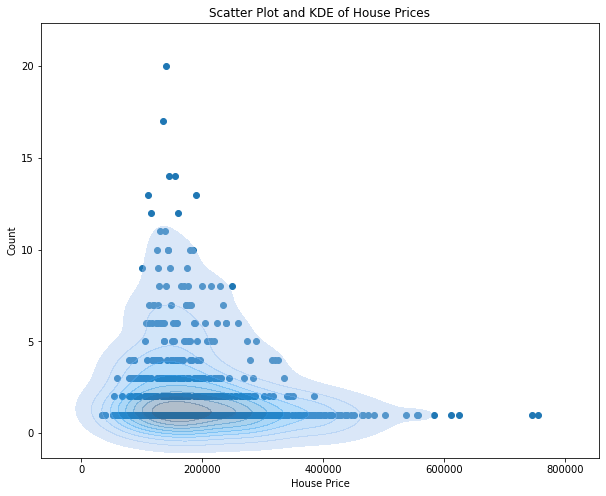

In [9]:
# define house price value counts
house_price_count = train_df["SalePrice"].value_counts().to_dict()

# plotting the distribution of (target) house price counts seen in the dataset
fig, axs = plt.subplots(figsize=(10, 8))
axs.scatter(house_price_count.keys(), house_price_count.values())
axs.set_title("Scatter Plot and KDE of House Prices")
axs.set_xlabel("House Price")
axs.set_ylabel("Count")
sns.kdeplot(house_price_count.keys(), y=house_price_count.values(), ax=axs, 
            fill=True, levels=10, alpha=0.4)
plt.show()

The number of features that we have is too high for pairplot of every single features. Instead, I will be examining them as groups or as individuals, based on the three project level questions I posed above.

Text(0.5, 1.0, 'Count of Unique Values per Feature')

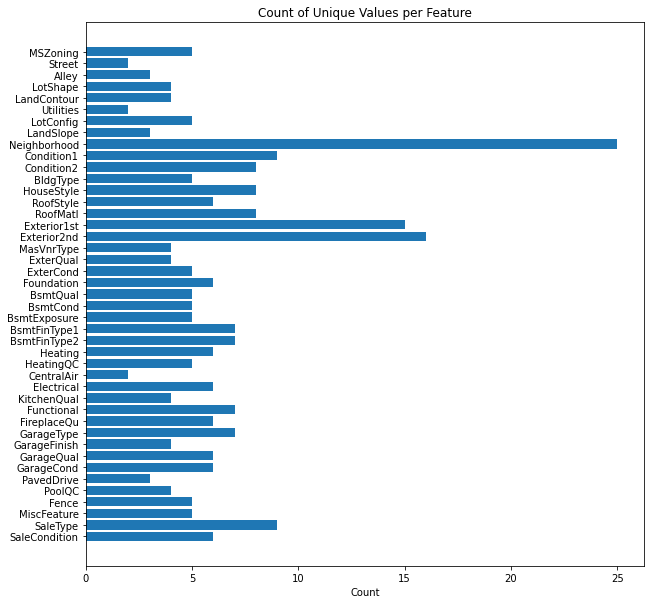

In [10]:
# take the number of unique values for each categorical feature
feature_dict = train_df.loc[:, train_df.columns[train_df.dtypes == "category"]].nunique().to_dict()

# plot the number of unique values per feature
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(np.arange(len(feature_dict)), feature_dict.values(), align="center")
ax.set_yticks(np.arange(len(feature_dict)), labels=feature_dict.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Count")
ax.set_title("Count of Unique Values per Feature")

A lot of the features are highly correlated, and so can be boiled down to: location, quality of property (build-wise or with respect to furnishing) which correlates amount of amenities/facilities available, and lastly the area of the property in square feet.

I will be choosing a few features based on heuristics for visualizations. They will fall into the aforementioned categories. The features chosen are:
1. Neighborhood - this feature describes the neighborhood the property is in, and since it has no null value, it is likely to encompass the information in other features such as MSZoning as well. The null hypothesis being that the particular neighborhood will affect the property prices drastically and this will also correlate strongly with features such as MSZoning, as well as having a higher descriptive power. 
2. OverallCond & OverallQual - these features summarize the overall quality of the house, build quality wise and with respect to the condition it's in.
3. LotArea - this feature denotes the total area in square feet of the property, likely to correlate with price and other strong predictive features. 

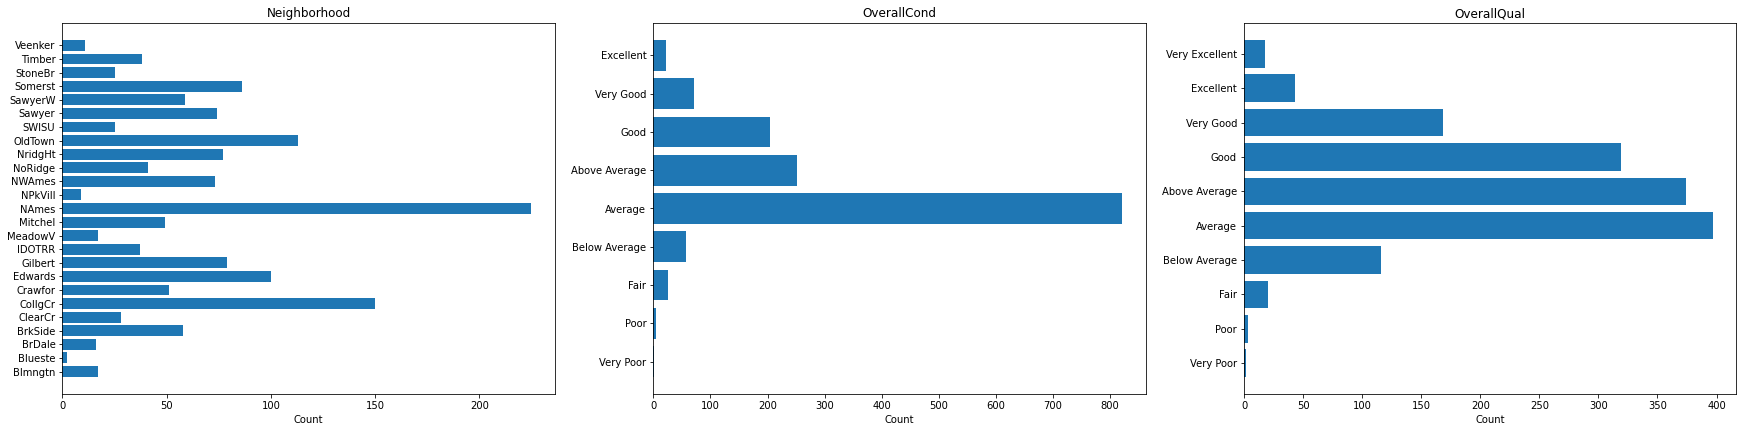

In [11]:
# categorical columns in this list
cols_to_plot = ["Neighborhood", "OverallCond", "OverallQual"]

# plot the value counts of figures as bar charts
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known
Tot = len(cols_to_plot) + 1
Cols = 3

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index
Position = range(1, Tot + 1)

# Create main figure
fig = plt.figure(1, figsize=(30, 15))
for k in range(len(cols_to_plot)):
    # add every single subplot to the figure with a for loop
    ax = fig.add_subplot(Rows, Cols, Position[k])
    cols_to_plot_dict = train_df.loc[:, cols_to_plot[k]].value_counts().to_dict()
    cols_to_plot_dict = {k: v for k, v in sorted(cols_to_plot_dict.items(), key=lambda item: item[0])}
    ax.barh(np.arange(len(cols_to_plot_dict.keys())), cols_to_plot_dict.values())
    if k:
        labels = {
            10:	"Very Excellent",
            9:	"Excellent",
            8:	"Very Good",
            7:	"Good",
            6:	"Above Average",
            5:	"Average",
            4:	"Below Average",
            3:	"Fair",
            2:	"Poor",
            1:	"Very Poor"
        }
        labels_ = [labels[i] for i in cols_to_plot_dict.keys()]
        ax.set_yticks(np.arange(len(cols_to_plot_dict)), labels=labels_)
    else:
        ax.set_yticks(np.arange(len(cols_to_plot_dict)), labels=cols_to_plot_dict.keys())
    # ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel("Count")
    ax.set_title(cols_to_plot[k])

plt.show()

We can see that the average quality properties appear more often in the data, which is to be expected. 

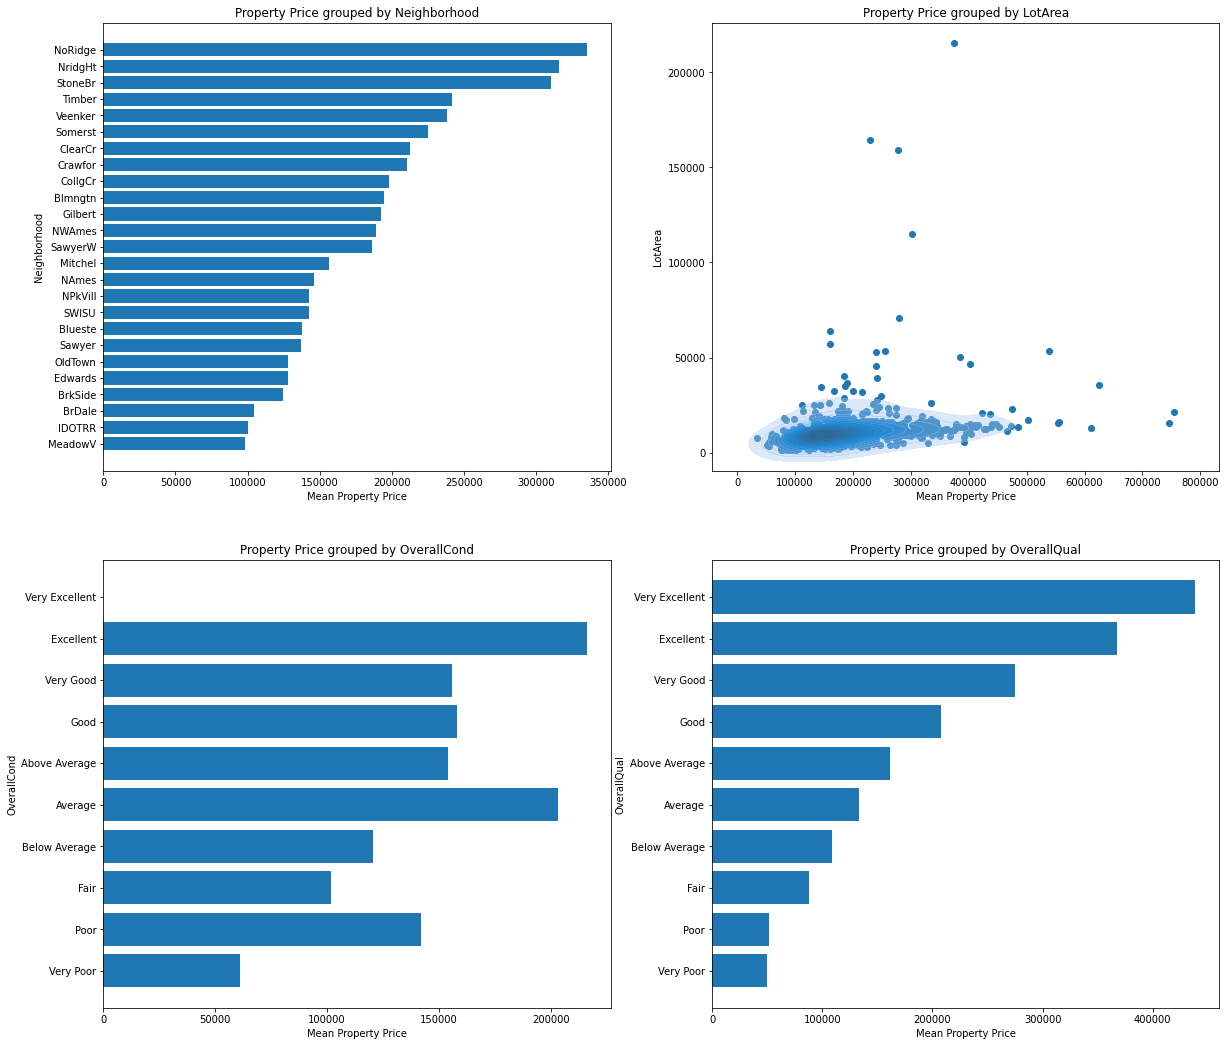

In [12]:
# define columns to plot
cols_to_plot = ["Neighborhood", "LotArea", "OverallCond", "OverallQual"]

# plot the value counts of figures as bar charts
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known
Tot = len(cols_to_plot) + 1
Cols = 2

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index
Position = range(1, Tot)

# we want to also do partial dependence plots for these three columns
# Create main figure
fig = plt.figure(1, figsize=(20, 28))
for k in range(len(cols_to_plot)):
    # add subplot to the figure with a for loop
    ax = fig.add_subplot(Rows, Cols, Position[k])
    if k >= 2:
        cols_to_plot_dict = train_df.groupby(cols_to_plot[k])["SalePrice"].mean().to_dict()
        cols_to_plot_dict = {k: v for k, v in sorted(cols_to_plot_dict.items(), key=lambda item: item[0])}
        if k != 2:
            ax.barh(np.arange(10), cols_to_plot_dict.values())
        else:
            ax.barh(np.arange(10), list(cols_to_plot_dict.values()) + [0])
        labels = {
            10:	"Very Excellent",
            9:	"Excellent",
            8:	"Very Good",
            7:	"Good",
            6:	"Above Average",
            5:	"Average",
            4:	"Below Average",
            3:	"Fair",
            2:	"Poor",
            1:	"Very Poor"
        }
        labels_ = [labels[i] for i in cols_to_plot_dict.keys()]
        if k == 2: labels_ = [labels[i] for i in cols_to_plot_dict.keys()] + ["Very Excellent"]
        ax.set_yticks(np.arange(10), labels=labels_)
    elif not k:
        cols_to_plot_dict = train_df.groupby(cols_to_plot[k])["SalePrice"].mean().to_dict()
        cols_to_plot_dict = {k: v for k, v in sorted(cols_to_plot_dict.items(), reverse=False, key=lambda item: item[1])}
        ax.barh(np.arange(len(cols_to_plot_dict.keys())), cols_to_plot_dict.values())
        ax.set_yticks(np.arange(len(cols_to_plot_dict)), labels=cols_to_plot_dict.keys())
    else:
        cols_to_plot_dict = train_df.groupby(cols_to_plot[k])["SalePrice"].mean().to_dict()
        ax.scatter(cols_to_plot_dict.values(), cols_to_plot_dict.keys())
        sns.kdeplot(cols_to_plot_dict.values(), y=cols_to_plot_dict.keys(), ax=ax, 
                    fill=True, levels=15, alpha=0.4)
        
    ax.set_xlabel("Mean Property Price")
    ax.set_ylabel(cols_to_plot[k])
    ax.set_title(f"Property Price grouped by {cols_to_plot[k]}")

plt.show()

We expect the property build quality and condition to be proportional to the average price, but that doesn't always seem to hold. 

## Feature engineering

I will split the original data into train and validation sets for selecting the best model families. Then the test set will be used for model optimization.

First, I will convert the dataframe into NumPy array, then apply preprocessing steps. I will be normalizing the data by mean and standard deviation of training set for features that are ordinal encoded.

My preprocessing choices include ordinal encoding for categorical features that can be sorted, for example features that takes the value range "Excellent" -> "Bad", and one hot encoding for features that cannot be meaningfully ordered. 

In [13]:
# list of categorical columns to encode both ways
cat_one_hot_cols = ["MSSubClass", "MSZoning", "Street", "Alley", "LotConfig", 
                    "Neighborhood", "Condition1", "Condition2", "BldgType",
                    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                    "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical",
                    "GarageType", "MiscFeature", "SaleType", "SaleCondition"]
cat_ord_cols = ["LotShape", "LandContour", "LandSlope", "OverallQual", "Utilities",
                "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
                "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual",
                "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond",
                "PavedDrive", "PoolQC", "Fence"]


# encode features with ordinal encoder
ode = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1).fit(train_df[cat_ord_cols])
train_df[cat_ord_cols] = ode.transform(train_df[cat_ord_cols])
test_df[cat_ord_cols] = ode.transform(test_df[cat_ord_cols])

# remove house price from data
y_train = train_df["SalePrice"].to_numpy()
train_df = train_df.drop("SalePrice", axis=1, inplace=False)  # to_numpy will be automatically applied with encoder

# encode features with one hot encoder
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

# make sure that the values present in the train set is 
# created as columns in the test set and vice versa
in_train_not_test = [c for c in train_df.columns.to_list() if c not in test_df.columns]
test_df[in_train_not_test] = 0
in_test_not_train = [c for c in test_df.columns.to_list() if c not in train_df.columns]
train_df[in_test_not_train] = 0

# reorder in case the previous steps created new features in test_df
test_df.columns = train_df.columns.to_list()

I will also show where the test data differs in categorical values seen, which I will encode unknown values with -1, and I will print out the values that aren't seen in the training data.

In [14]:
print("Categories seen during the ordinal encoding process:")
print()
for _ in ode.categories_:
    print("    ", _)

Categories seen during the ordinal encoding process:

     ['IR1' 'IR2' 'IR3' 'Reg']
     ['Bnk' 'HLS' 'Low' 'Lvl']
     ['Gtl' 'Mod' 'Sev']
     [ 1  2  3  4  5  6  7  8  9 10]
     ['AllPub' 'NoSeWa']
     [1 2 3 4 5 6 7 8 9]
     ['Ex' 'Fa' 'Gd' 'TA']
     ['Ex' 'Fa' 'Gd' 'Po' 'TA']
     ['Ex' 'Fa' 'Gd' 'None' 'TA']
     ['Fa' 'Gd' 'None' 'Po' 'TA']
     ['Av' 'Gd' 'Mn' 'No' 'None']
     ['ALQ' 'BLQ' 'GLQ' 'LwQ' 'None' 'Rec' 'Unf']
     ['ALQ' 'BLQ' 'GLQ' 'LwQ' 'None' 'Rec' 'Unf']
     ['Ex' 'Fa' 'Gd' 'Po' 'TA']
     ['Ex' 'Fa' 'Gd' 'TA']
     ['Maj1' 'Maj2' 'Min1' 'Min2' 'Mod' 'Sev' 'Typ']
     ['Ex' 'Fa' 'Gd' 'None' 'Po' 'TA']
     ['Fin' 'None' 'RFn' 'Unf']
     ['Ex' 'Fa' 'Gd' 'None' 'Po' 'TA']
     ['Ex' 'Fa' 'Gd' 'None' 'Po' 'TA']
     ['N' 'P' 'Y']
     ['Ex' 'Fa' 'Gd' 'None']
     ['GdPrv' 'GdWo' 'MnPrv' 'MnWw' 'None']


Normally, when we don't have a large amount of data, ideally we should have a enough for train/val/test in the ratio of 60/20/20 using something like sklearn's train_test_split as in this example:

    # split data into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(train_df, target, train_size=0.8, random_state=global_seed)

But since we don't (and that this is a fairly simple example), I will be trying to estimate the generalization error with a 5-fold validation process on the training set. The K-fold procedure will be done in GridSearchCV later on.

In [15]:
# normalize the data
std_scaler = StandardScaler().fit(train_df)
x_train = std_scaler.transform(train_df)
x_test = std_scaler.transform(test_df)

The reason why I used StandardScaler here is because of my model of choice being gradient boosted trees, which requires propagating gradients during its training process. By normalizing the values with their column's mean and standard deviation, we make the process more numerically stable by reducing the magnitude of the values, and also we are effectively ensuring that all features don't affect the gradient by different amounts due to relative magnitudes. 

## Model Fitting

I will be trying out GradientBoosting. I chose the tree-based model for the built-in feature importance capabilities, and due to its simplicity. 

Note that We saw from before that the property prices are fairly concentrated and there doesn't seem to be any artificial boundary with respect to the actual prices. 

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


# model instantiation and fitting with gridsearch
gb_regressor_base = GradientBoostingRegressor()
gb_search_params = dict(
    learning_rate=[0.05, 0.1], 
    n_estimators=[100, 150], 
    min_samples_split=[2, 3], 
    min_samples_leaf=[1, 2, 3],
    max_depth=[2, 3], 
    random_state=[global_seed]
)
gb_regressor = GridSearchCV(gb_regressor_base, gb_search_params, n_jobs=4, verbose=2)
gb_regressor.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 150], 'random_state': [42]},
             verbose=2)

We can see that sklearn's GridSearchCV returned a number of fitted results, including detailed metrics logged during cross validation, which in this case is the default 5-fold cross validation. We also can access the information about the best fit during the process.  

In [17]:
print(f"Best estimator is: {gb_regressor.best_estimator_}, \
      where the default parameters is used for all unlisted parameters.")
print(f"Best goodness-of-fit score throughout hyperparameter search is: {gb_regressor.best_score_}")

Best estimator is: GradientBoostingRegressor(min_samples_split=3, n_estimators=150,
                          random_state=42),       where the default parameters is used for all unlisted parameters.
Best goodness-of-fit score throughout hyperparameter search is: 0.8954423430416242


We will then be using the best fitted estimator to predict our validation data. Then after making the validation predictions and seeing how our model performs on unseen data, we will explore what the feature importances are for our model. 

## Post Modelling Exploration

Now that we have our best model, we can try to get the feature importances, and see if they line up with our expectations.

We expect that, with respect to the questions:
1. The geography will be influential when it comes to determining the property prices. Since the locations are grouped and one-hotted, some locations might have more variance when it comes to prices, but the trend should be seen from the price/location.
2. As for physical conditions of the house, we also expect a positive correlation, although not exactly linear. These features are ordinal encoded for the most part, and we will be able to check how their values affect the predictions. 
3. The features containing sales information are few in numbers, but we also expect some correlation with the prices. 

First, let's see what the top-5 and top-20 most important features are. Note that I could use top 10 or a smaller number, but since I one-hotted the features, I can't plot the importances after transforming them back, so I want to do this for inclusivity. 

Text(0.5, 1.0, 'Top-5 Feature Importances by Reduction of Loss')

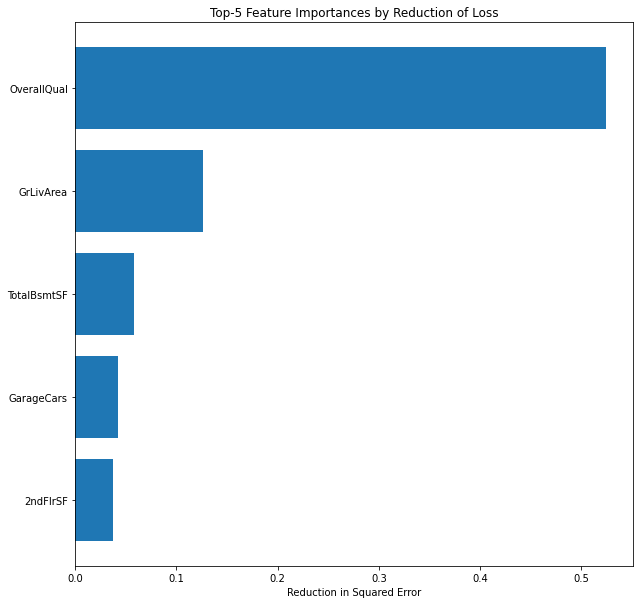

In [18]:
# feature importances from best estimator
feature_importances = gb_regressor.best_estimator_.feature_importances_
top_5_feat_ = np.argpartition(feature_importances, -5)[-5:]
top_5_labels = train_df.columns[top_5_feat_]
# a hack for sorting the dictionaries for plotting
top_5_feat = dict(sorted(zip(top_5_labels, feature_importances[top_5_feat_]), key=lambda item: item[1]))

# map our numerical features back to their columns
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(
    np.arange(len(top_5_feat)),
    top_5_feat.values()
)
plt.yticks(np.arange(len(top_5_feat)), 
           labels=top_5_feat.keys())
plt.xlabel("Reduction in Squared Error")
plt.title("Top-5 Feature Importances by Reduction of Loss")

We can see that the "OverallQual" feature is the most important feature when it comes to reducing the loss. There by affirming our hypothesis about the physical aspects of the property affecting the prices, and we also saw from before that average property prices scale linearly with respect to the quality.

Along with the overall build quality, we also see that features concerning space are also very determining, with ground living area in square feet taking second place. This might lead us to another hypothesis being that the actual living area is more important than the overall area. 

I will now plot the top 3-20 features, since the top 2 features would otherwise skew the plots too much for comparisons to be straightforward. 

Text(0.5, 1.0, 'Top 3-20th Feature Importances by Reduction of Loss')

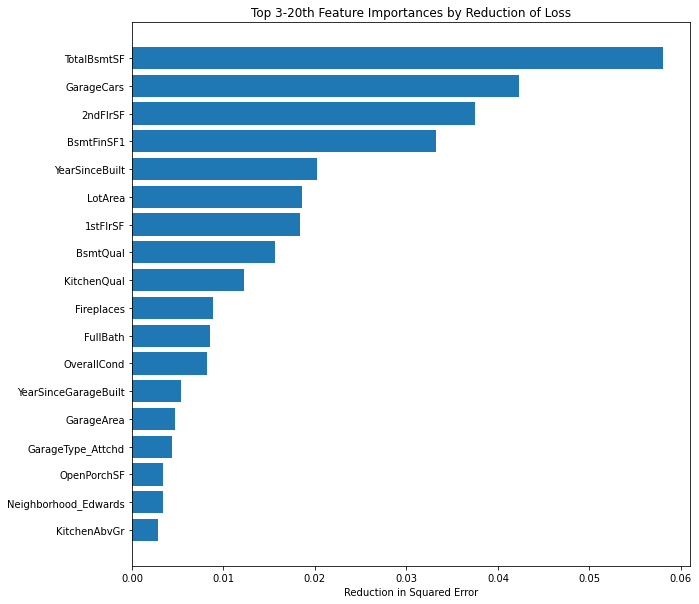

In [19]:
# feature importances from best estimator
top_20_feat_ = np.argpartition(feature_importances, -20)[-20:]
top_20_labels = train_df.columns[top_20_feat_]
# a hack for sorting the dictionaries for plotting
top_3_20_feat = dict(sorted(zip(top_20_labels, feature_importances[top_20_feat_]), key=lambda item: item[1])[:-2])

# map our numerical features back to their columns
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(
    np.arange(len(top_3_20_feat)),
    top_3_20_feat.values()
)
plt.yticks(np.arange(len(top_3_20_feat)), 
           labels=top_3_20_feat.keys())
plt.xlabel("Reduction in Squared Error")
plt.title("Top 3-20th Feature Importances by Reduction of Loss")

With respect to the three questions I set out earlier, I will examine the data accordingly. When it comes to locational features, they have a lot of unique values, and on their own, can be basically a sparse submatrix, so this wouldn't be reflected well when using a feature importance metric based on loss. 

Confirming our second question, a lot of the top features are based on the physical aspects of the house, and include many auxilliary features such as bath availability, kitchen area, etc. 

The two features regarding sales conditions "SaleCondition" and "SaleType" are not seen in the top 20 feature importances outputed by our gradient boosted tree regressor. 

There are more in-depth analysis that can be done, and should be done had it been a more realistic dataset, but I hope that this is indicative of a process that you could take when it comes to making sense of such a dataset.